# 0.0. IMPORTS

In [42]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import datetime

# 0.1. Helper Functions

# 0.2. Loading Data

In [7]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False) # raw e pq acabou de ler o arqivo e nao fez nnhuma alteracao ainda
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge = junta os dois dataframes em um so
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [8]:
df_sales_raw[df_sales_raw['Store'] == 1]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1011635,1,6,2013-01-05,4997,635,1,0,0,1
1012750,1,5,2013-01-04,4486,619,1,0,0,1
1013865,1,4,2013-01-03,4327,578,1,0,0,1
1014980,1,3,2013-01-02,5530,668,1,0,0,1


In [9]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
691286,772,7,2013-10-20,0,0,0,0,0,0,d,c,1850.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0. STEP 01 - DATA DESCRIPTION

In [10]:
df1 = df_raw.copy() # copia dos dados originais, caso tenho um erro nessa sessao, os dados da sessao anterios estao salvos.

## 1.1. Rename Columns

In [11]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [12]:
# alterando os nomes das colunas
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# funcao que altera o nome das colunas para o tipo snakecase
snakecase = lambda x: inflection.underscore(x)

# map faz o mapeamento da funcao snakecase em todas as palavras da variavel cols_old
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

In [13]:
df1.columns # as colunas estao no tipo snakecase agora

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [14]:
# saber qal e o amanho de linhas e colunas
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [15]:
df1['date'] = pd.to_datetime(df1['date']) # alterando o tipo da coluna date para date time
df1.dtypes # mostra os tipos das colunas

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [16]:
df1.isna().sum() # verifica a quantidade de na em cada coluna

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA using business logic

In [17]:
# competition_distance 
# Nesta coluna, NA significa q a loja nao tem competicao proxima ou entao q a loja competidora esta muito longe. 
#Com isso, para remover os NAs desta coluna, podemos colocar uma distancia maior do que a distancia maxima entre as lojas. 

#funcao q substitui todos os NAs das colunas por uma distancia maior do que a distancia maxima entre as lojas, neste caso, 
#200000
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
#obs a funcao math.isnan so funcionanna funcao lambda mais apply, sozinho a funcao math.isnan nao funciona

# competition_open_since_month
# Nesta coluna, se for NA, copia-se o mes da data de venda daquela linha, da coluna date, para a coluna competition_open_since_month.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else
                                                          x['competition_open_since_month'], axis =1)
#obs: tem o nome das colunas do lado do x nesse pois usa-se mais de uma coluna 

#competition_open_since_year 
# Nesta coluna, se for NA, copia-se o ano da data de venda daquela linha, da coluna date, para a coluna competition_open_since_year.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else
                                                          x['competition_open_since_year'], axis =1)
                    
#promo2_since_week     
# Nesta coluna, se for NA, copia-se a semana da data de venda daquela linha, da coluna date, para a coluna promo2_since_week .
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else
                                                          x['promo2_since_week'], axis =1)
#promo2_since_year  
# Nesta coluna, se for NA, copia-se a ano da data de venda daquela linha, da coluna date, para a coluna promo2_since_week .
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else
                                                          x['promo2_since_year'], axis =1)

#promo_interval   
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True) # substitui os NAs da coluna por 0, e inplace = True serve deixar essa substituicao como definitivo

df1['month_map'] = df1['date'].dt.month.map(month_map) # cria-se uma nova coluna, onde se copia os meses da coluna date, 
#de cada linha, para esta nova coluna, e transforma estes meses em string  com o auxulio do dicionario criado acima e da funcao .map.

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 
                                                                       1 if x['month_map'] in x['promo_interval'].split(',') else 
                                                                       0,axis = 1)
# split quebra o array separado por virgula e transforma em lsita
#cria-se uma coluna nova chamada is_promo, onde e criada baseada em duas condicoes:

#primeira:
# Se o mes da coluna 'month_map estiver incluso na coluna promo_interval, o valor da coluna is_promo e 1, 
# Se o mes da coluna 'month_map nao estiver incluso na coluna promo_interval, o valor da coluna is_promo e 0.

#segunda
# Se o valor da linha da coluna 'promo_interval for 0, o valor da coluna is_promo e 0,
# Se o valor da linha da coluna 'promo_interval NAO for 0, o valor da coluna is_promo e 1.


In [18]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [19]:
df1.sample(5).T

,349812,53752,384925,343582,387761
store,358,233,975,738,1011
day_of_week,1,6,6,1,3
date,2014-09-01 00:00:00,2015-06-13 00:00:00,2014-07-26 00:00:00,2014-09-08 00:00:00,2014-07-23 00:00:00
sales,17114,8918,4783,7094,6746
customers,1569,956,490,684,787
open,1,1,1,1,1
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,1
store_type,a,a,a,d,a


### 1.5.1 Fillout NA (alternativa criada por mim tbm usando logica de negocios)

In [24]:
# # competition_open_since_month
# Nesta coluna, se for NA, copia-se o primeiro mes de compra da coluna data, referente a cada valor de store,
#para a coluna competition_open_since_month.
first_month_year = df1[['store', 'date']].groupby('store').min().reset_index()
first_month_year.columns = ['store', 'first_month_year']
df2 = pd.merge(df1,first_month_year,on='store',how='inner')

df2['competition_open_since_month'] = df2.apply(lambda x: x['first_month_year'].month if math.isnan(x['competition_open_since_month']) else
                                                          x['competition_open_since_month'], axis =1)

# # competition_open_since_year
# Nesta coluna, se for NA, copia-se o primeiro ano de compra da coluna data, referente a cada valor de store,
#para a coluna competition_open_since_year.
df2['competition_open_since_year'] = df2.apply(lambda x: x['first_month_year'].year if math.isnan(x['competition_open_since_year']) else
                                                          x['competition_open_since_year'], axis =1)

#promo2_since_week     
# Nesta coluna, se for NA, copia-se a primeira semana de compra da coluna data, referente a cada valor de store,
#para a coluna promo2_since_week .
df2['promo2_since_week'] = df2.apply(lambda x: x['first_month_year'].week if math.isnan(x['promo2_since_week']) else
                                                          x['promo2_since_week'], axis =1)
#promo2_since_year  
# Nesta coluna, se for NA, copia-se o primeiro ano de compra da coluna data, referente a cada valor de store,
#para a coluna competition_open_since_year.
df2['promo2_since_year'] = df2.apply(lambda x: x['first_month_year'].year if math.isnan(x['promo2_since_year']) else
                                                          x['promo2_since_year'], axis =1)


In [16]:
df2[['store', 'date', 'competition_open_since_month', 'competition_open_since_year', 'first_month_year','promo2_since_week', 'promo2_since_year']]

,store,date,competition_open_since_month,competition_open_since_year,first_month_year,promo2_since_week,promo2_since_year
0,1,2015-07-31,9.0,2008.0,2013-01-01,31.0,2015.0
1,1,2015-07-30,9.0,2008.0,2013-01-01,31.0,2015.0
2,1,2015-07-29,9.0,2008.0,2013-01-01,31.0,2015.0
3,1,2015-07-28,9.0,2008.0,2013-01-01,31.0,2015.0
4,1,2015-07-27,9.0,2008.0,2013-01-01,31.0,2015.0
...,...,...,...,...,...,...,...
1017204,1115,2013-01-05,1.0,2013.0,2013-01-01,22.0,2012.0
1017205,1115,2013-01-04,1.0,2013.0,2013-01-01,22.0,2012.0
1017206,1115,2013-01-03,1.0,2013.0,2013-01-01,22.0,2012.0
1017207,1115,2013-01-02,1.0,2013.0,2013-01-01,22.0,2012.0


In [17]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year                    0
promo_interval                  508031
first_month_year                     0
dtype: int64

## 1.6. Change Types

In [20]:
# Depois de criar ou aletrar colunas e bom checar os tipos das colunas novamente

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [23]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

In [24]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [25]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])# seleciona as colunas pelo tipo, neste caso, numericas
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])# exclui as colunas pelo tipo, neste caso, numericas

## 1.7.1 Numerical Atributes

In [26]:
#central tendency - media, mediana
ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T # funcao apply aplica qualquer funcao nas colunas ou linhas da variaves
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T

#dispersion - std, min ,max, range, skew, kurtosis
d1 = pd.DataFrame (num_attributes.apply(np.std)).T
d2 = pd.DataFrame (num_attributes.apply(min)).T
d3 = pd.DataFrame (num_attributes.apply(max)).T
d4 = pd.DataFrame (num_attributes.apply(lambda x: x.max() - x.min())).T # range
d5 = pd.DataFrame (num_attributes.apply(lambda x: x.skew())).T # skew
d6 = pd.DataFrame (num_attributes.apply(lambda x: x.kurtosis())).T # kurtosis

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [27]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.000,1115.000,1114.000,558.430,558.000,321.908,-0.001,-1.201
1,day_of_week,1.000,7.000,6.000,3.998,4.000,1.997,0.002,-1.247
2,sales,0.000,41551.000,41551.000,5773.819,5744.000,3849.924,0.641,1.778
3,customers,0.000,7388.000,7388.000,633.146,609.000,464.412,1.599,7.092
4,open,0.000,1.000,1.000,0.830,1.000,0.376,-1.758,1.091
5,promo,0.000,1.000,1.000,0.382,0.000,0.486,0.488,-1.762
6,school_holiday,0.000,1.000,1.000,0.179,0.000,0.383,1.678,0.815
7,competition_distance,20.000,200000.000,199980.000,5935.443,2330.000,12547.647,10.242,147.790
8,competition_open_since_month,1.000,12.000,11.000,6.787,7.000,3.311,-0.042,-1.233
9,competition_open_since_year,1900.000,2015.000,115.000,2010.325,2012.000,5.516,-7.236,124.071


C:\Users\Igor\anaconda3\envs\Data-Science-Em-Producao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

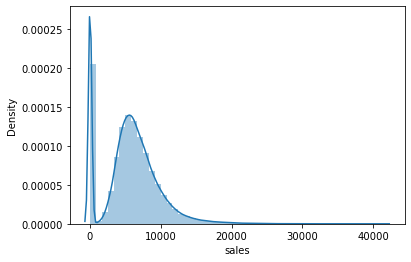

In [28]:
sns.distplot(df1['sales']) # futuramente usar displot ou histplot
# coluna proxima de uma normal, um pouco deslocada para a esquerda pq a media e a mediana sao doferentes e a skew e positiva

C:\Users\Igor\anaconda3\envs\Data-Science-Em-Producao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

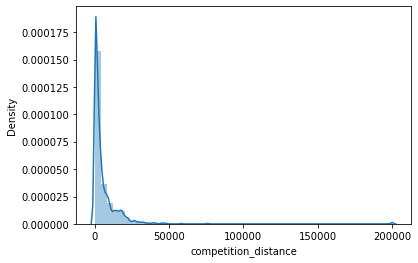

In [29]:
sns.distplot(df1['competition_distance'])
# ao verificar o Descriptive Statistical, checa-se que a skew esta bem alta, super deslocada pra esquerda e a kurtosis 
# esta gigantesca, o q significa que e uma distribuicao tipo puason, onde o tem um pico bem alto no comeco, depois vai caindo,
# e tem uma concentracao muito alta de valores no comeco.
#Isto acontece pq os competidores esta proximos, com distancias pequenas, e concentracao grande perto do 0

## 1.7.2 Categorical Atributes

In [30]:
# para categorical attirbutes usa-se o boxplot, onde mostra todas as medidas de dispercao e central em um lugar so.

In [31]:
cat_attributes.apply(lambda x: x.unique().shape[0])
# funcao lambda que verifica a quantidade dos valores unitarios dos todas as colunas do dataset de uma vez 

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

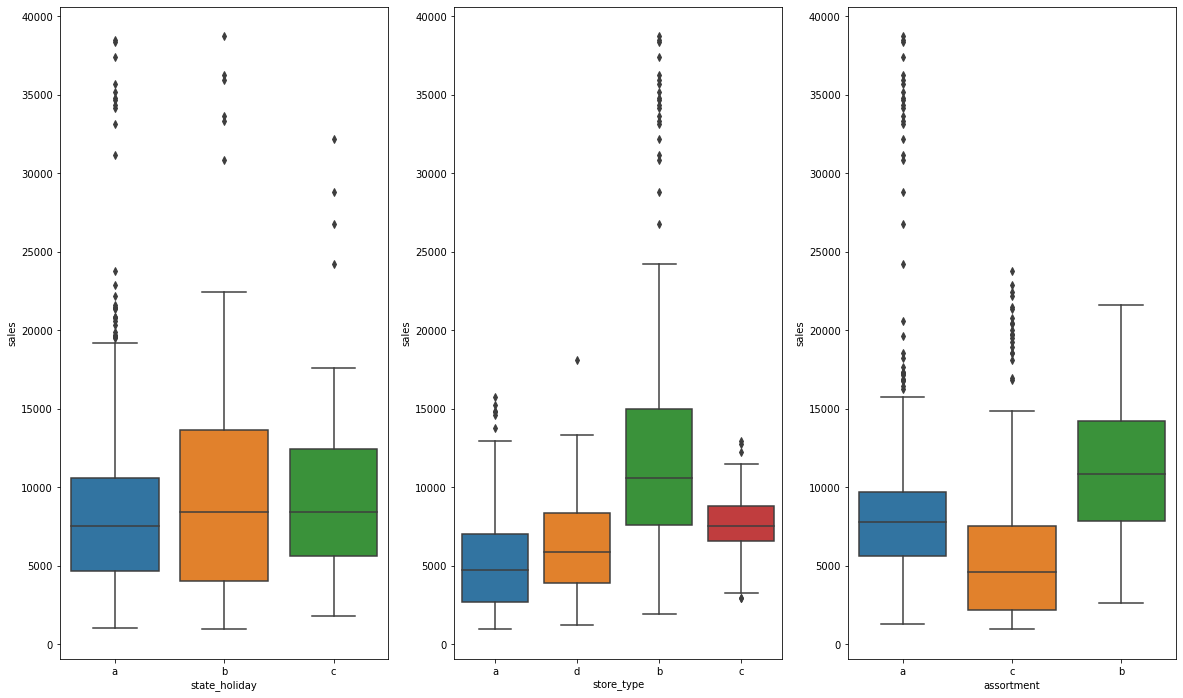

In [32]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

fig = plt.figure(figsize=(20,12)) 

fig.add_subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

fig.add_subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)

fig.add_subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)
# x  e a linha de referencia, o nome da categoria
# y e o q uer medir

In [33]:
#funcionamento do boxplot:

# a linha do meio do quadrado colorido e a 50º percentil  ou seja e a mediana
# a linha de baixo do quadrado colorido e a 25º percentil 
# a linha de cima do quadrado colorido e a 75º percentil 
# as linhas extremas sao 0º e 100º percentil (sao os valores minimos e maximos)

# este retangulo e dividido em 4 quartis,
# o 1º quartil esta entre os percentis 0 e 25 
# o 2º quartil esta entre os percentis 25 e 50 
# o 3º quartil esta entre os percentis 50 e 75 
# o 4º quartil esta entre os percentis 75 e 100 

# tudo fora dos valores minimos e maximos sao considerados outlires, q sao considerados como 3 vezes o desvio padrao.

# 2.0. STEP 02 - FEATURE ENGINEERING

In [34]:
df2 = df1.copy()

## 2.1. Mind Map Hyphotesis

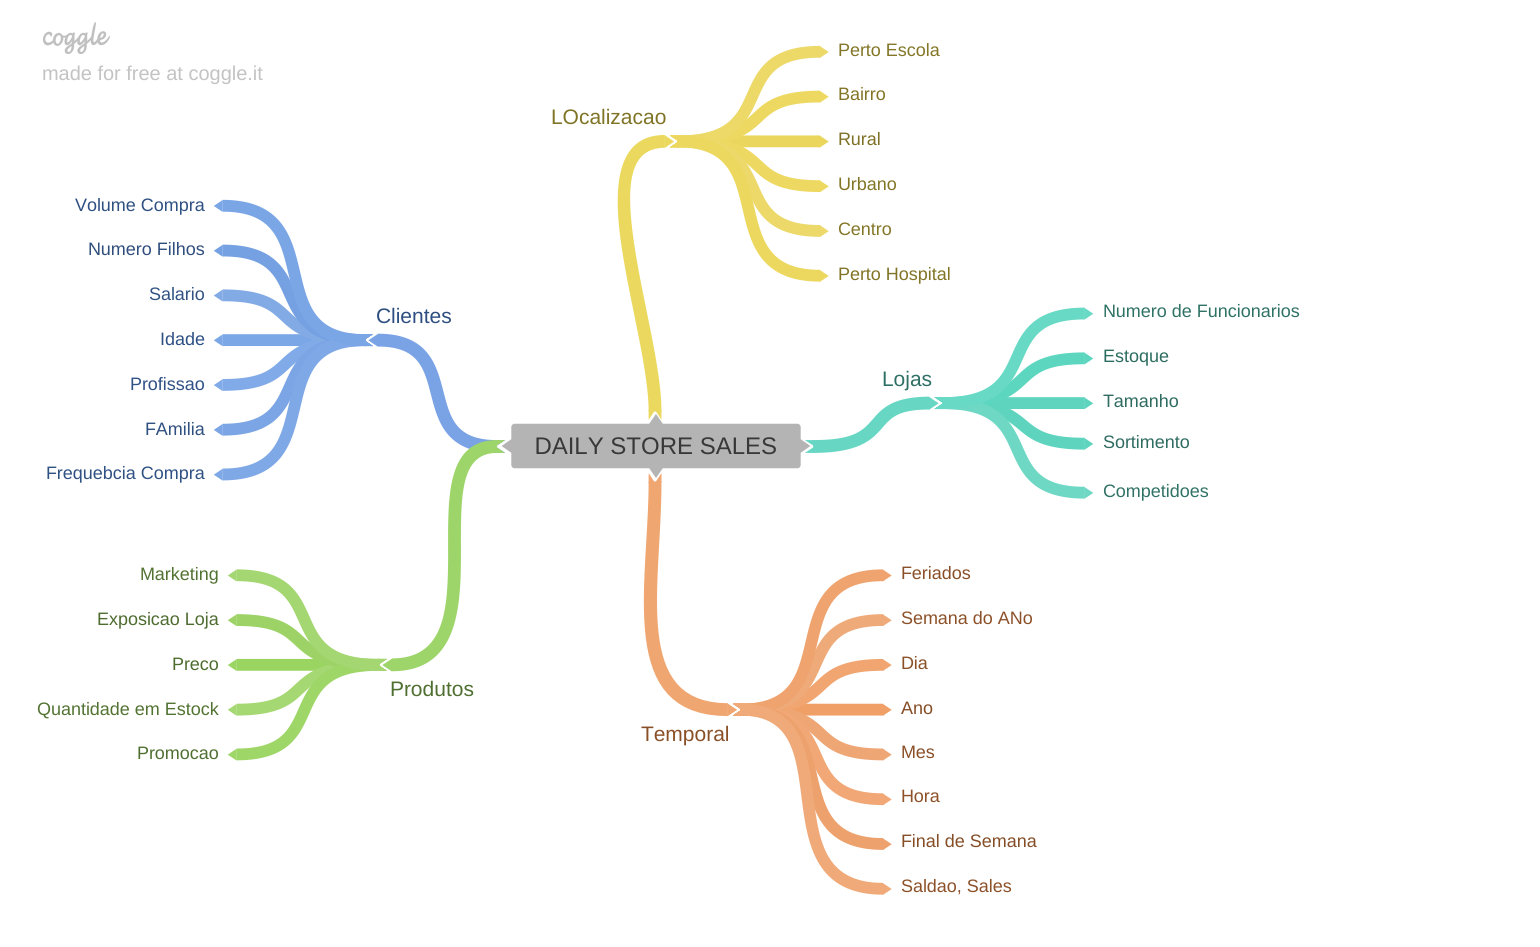

In [35]:
Image('img/MindMapHypothesis.png')

## 2.2. Hyphotesis Creation

### 2.1.1 Store Hypothesis

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortemento deveriam vender mais.

**5.** Lojas com competidores mais proximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2 Poduct Hypothesis

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem precos menores nos produtos deveriam vender mais.

**4.** Lojas com promocoes mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas com mais promocoes consecutivas deveriam vender mais.

### 2.1.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos aos fins de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Hyphotesis Final List

Aki se prioriza as hipoteses.

Para isso verifica-se se tem ou nao o dado disponivel no dataset para fazer a hipotese.

Caso com essas hipoteses o modelo tenha um desempeno ruim, ai sim cria-se novos dados para aplicar as novas hipoteses.

**1.** Lojas com maior sortemento deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promocao deveriam vender mais.

**6.** Lojas com mais promocoes consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos aos fins de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [48]:
# Variaveis a serem derivadas da variavel original date

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since (calcula,em meses, desde quando a competicao exsite ate a da data de compra)
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                 month = x['competition_open_since_month'], 
                                                                 day = 1), axis=1) # junta 3 colunas separadas (ano, mes e dia) 
                                                                                   # em uma coluna so com as 3 informacoes

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(np.int64)
# diminui data de compra pela data de competicao, e divide por 30, para manter a granularidade de mes

# promo since ( desde quando tem a promocao ativa)
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) # juntando as colunas 
                                                                                                    # em forma de string
    
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
# transformando a coluna do tipo str para o tipo data.

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(np.int64)
# diminui data de compra pela data de promocao, e divide por 7, para manter a granularidade de semanas


# assortment (trocar as letras por nome por extenso)
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic'    if x == 'a' else
                                                      'extra'    if x == 'b' else
                                                      'extended'                  )

# state holiday (trocar as letras por nome por extenso)
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x == 'a' else
                                                            'Easter holiday' if x == 'b' else
                                                            'Christmas'      if x == 'c' else
                                                            'regular_day'                     )

In [49]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. STEP 03 - Variables Filter

In [50]:
df3 = df2.copy()

In [51]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Rows Filter

In [53]:
### Restricao de Negocio:

# Open: PQ nao se usa as linhas onde as lojas estao fechadas, pois nao tem venda nessas linhas, logo joga-se fora todas as 
# linhas que tem como valor 0 fora.
#'open' != 0#

# Sales: Excluir as linhas q tem valor 0, pois essas nao sao uteis para predicao.
#'sales' > 0#

df3 = df3[(df3['open'] !=0) & (df3['sales'] >0)]

## 3.2. Columns Selection

In [54]:
### Restricao de Negocio:

#Customers: PQ como se precisa de uma predicao somente para daki a 6 semanas, nao teremos a quantidade de clientes por dia, 
# a partir de hj ate daki a 6 semanas, so temos de hj para traz. Por isso joga-se essa coluna fora.

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# open deletada pq so tem 1 entao nao e relevante, e 'promo_interval', 'month_map' deletadas pq sao colunas auxiliares para
# outras colunas.

In [55]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')